# Dependencies loading

In [100]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tf_explain.core.integrated_gradients import IntegratedGradients

# Keras Tuner
import keras_tuner as kt

In [102]:
import warnings
warnings.filterwarnings('ignore')

# Data loading

In [105]:
fifa_url = "https://raw.githubusercontent.com/Niyetali/FIFA-Rating-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{fifa_url}/X_train_fe.csv", sep=',')
X_test = pd.read_csv(f"{fifa_url}/X_test_fe.csv", sep=',')
y_train = pd.read_csv(f"{fifa_url}/y_train.csv", sep=',')
y_test = pd.read_csv(f"{fifa_url}/y_test.csv", sep=',')

pd.set_option('display.max_columns', None)

# Print shapes of the datasets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(14100, 42) (3525, 42)
(14100, 1) (3525, 1)


In [107]:
X_train.head()

,Name,Age,Nationality,Potential,Club,International Reputation,Weak Foot,Skill Moves,Body_Type,Attacking_Work_Rate,Defensive_Work_Rate,CB,CDM,CF,CM,GK,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RES,RF,RM,RS,RW,RWB,ST,SUB,BMI,Age_Group,Value_to_Potential
0,H. Stenevik,22,60.146444,74,61.582005,1.0,3.0,4.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,20.452885,0,14864.864865
1,22 T. Wooster,16,61.014790,73,69.208020,1.0,3.0,1.0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,22.353715,2,3150.684932
2,14 J. Rothen,35,66.254815,71,61.872308,2.0,2.0,3.0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,23.620288,1,4577.464789
3,22 D. Noboa,26,63.190972,70,63.101327,1.0,3.0,2.0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.589835,0,15714.285714
4,22 Baek Seung Woo,22,55.459091,62,59.455049,1.0,3.0,2.0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,22.491349,0,2903.225806


In [109]:
# Dropping the 'Name'
X_train = X_train.drop(columns=['Name'], errors='ignore')
X_test = X_test.drop(columns=['Name'], errors='ignore')

# Feature Scaling

In [112]:
# Scale features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Baseline Model: Feedforward Neural Network (FNN)

Our baseline regression model is simple and effective for starting out. It has just one dense layer with a linear activation, using the default SGD optimizer and mean squared error loss.

In [116]:
# Set random seed
seed = 56
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Initialize and build the model
model = Sequential([Dense(1, input_dim=X_train.shape[1], activation='linear')])

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42 (168.00 B)

 Trainable params: 42 (168.00 B)

 Non-trainable params: 0 (0.00 B)

In [118]:
# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 2986.1028 - val_loss: 991.5043
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 726.2557 - val_loss: 251.3673
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - loss: 181.5854 - val_loss: 69.3703
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - loss: 48.6319 - val_loss: 23.9462
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 15.9199 - val_loss: 12.0715
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - loss: 7.7189 - val_loss: 8.5562
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 5.5667 - val_loss: 7.2107
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - loss: 4.9384 - val_loss: 6.4936
Epoch 9/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 4.7129 - val_loss: 6.0064
Epoch 10/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 4.6060 - val_loss: 5.6357
Epoch 11/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 4.5419 - val_loss: 5.3415
Epoch 12/50
35

### Loss Curve

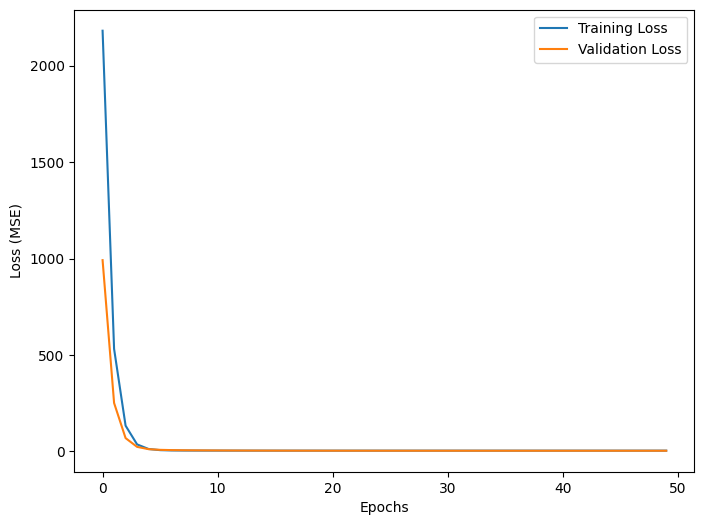

In [120]:
plt.figure(figsize=(8, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [121]:
# Evaluate the Model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")

Test Loss (MSE): 4.49070930480957


The **loss curve** shows a smooth decrease in both training and validation loss, converging after a few epochs. This indicates the model is learning effectively and generalizing well, with no signs of overfitting or underfitting. The final **Test Loss (MSE)** of **4.495**, calculated on unseen data, confirms the model's strong performance and sets a solid baseline for further improvements. 🚀

In [123]:
# Predictions
y_pred = model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


## Model Evaluation

In [125]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Adjusted R²
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

Mean Absolute Error (MAE): 1.6564757823944092
Mean Squared Error (MSE): 4.4907097816467285
Root Mean Squared Error (RMSE): 2.119129486757883
Mean Absolute Percentage Error (MAPE): 2.70%
R² Score: 0.9297192692756653
Adjusted R² Score: 0.9288919623679139


#### **Results**

The model's performance is strong:

- **MAE:** Predictions are off by about 1.656 units on average.

- **MSE:** The Mean Squared Error is low, indicating that the model's predictions have small overall errors and are consistent with the actual values.

- **RMSE:** The Root Mean Squared Error shows that the average error magnitude is low and provides an intuitive measure of prediction accuracy in the same scale as the target variable.

- **MAPE:** Predictions are only 2.7% off from actual values on average.

- **R²:** The model explains 93% of the variance in the data.

- **Adjusted R²:** The model generalizes well without overfitting.

### Predicted vs Actual Values

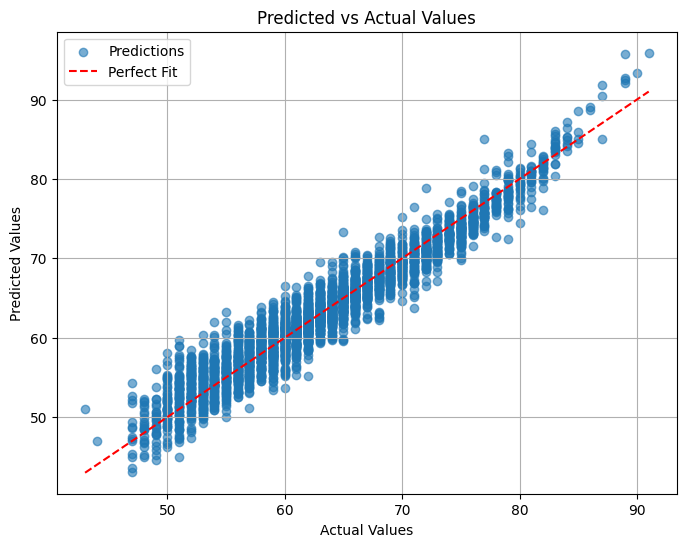

In [133]:
# Convert y_test and y_pred to 1D arrays with new names
actual_values = y_test.values.flatten()
predicted_values = y_pred.flatten()

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label='Predictions')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

The points are close to the red "Perfect Fit" line, showing that the model is predicting well. Most predictions are right on target, with only a few small errors.

### Residuals Plot

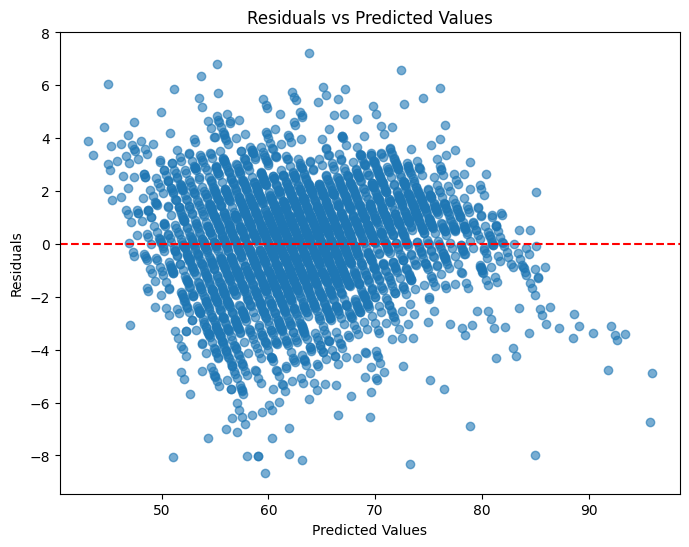

In [137]:
# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)

plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

The residuals are roughly evenly scattered around zero, showing unbiased predictions. The consistent spread indicates constant error variance, confirming the model captures the data's structure well.

### Distribution of Residuals

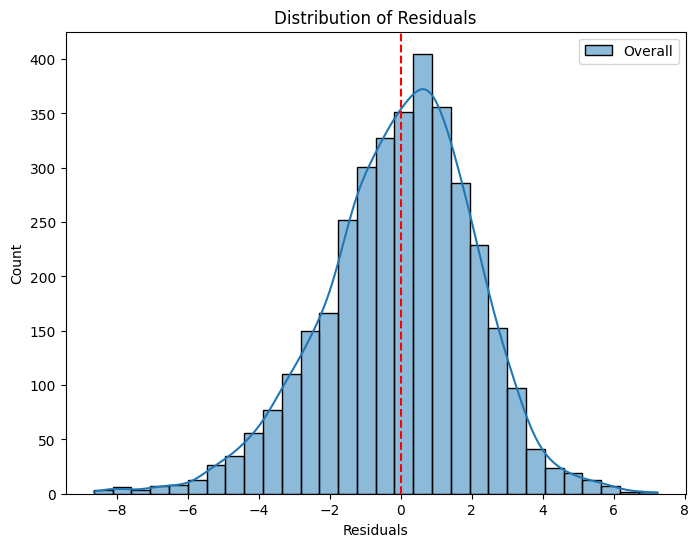

In [141]:
# Residual Distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

The residuals follow a roughly normal distribution, but with some **negative skew**, indicating that the model tends to **under-predict** in some cases. While the errors are generally centered around zero, the slight skew shows room for improvement in balancing the predictions. This is a good sign but shows there’s potential for refining the model further.

### Cumulative Error Distribution

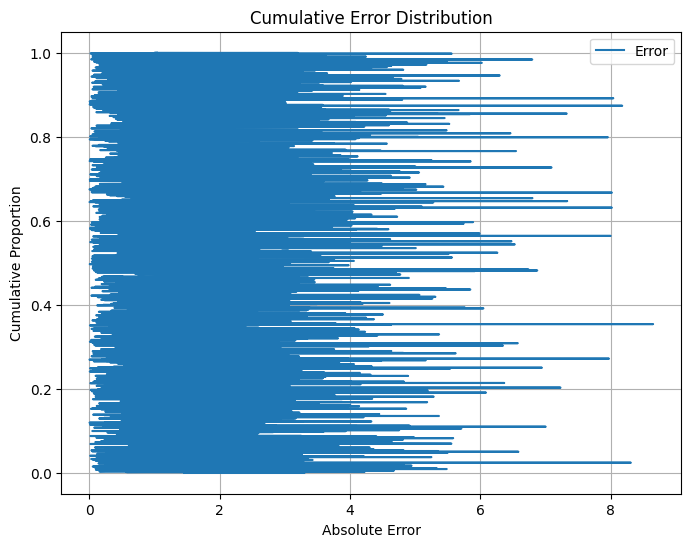

In [145]:
# Cumulative Error Distribution
absolute_errors = np.abs(y_test - y_pred)
sorted_errors = np.sort(absolute_errors)
cumulative_errors = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 6))
plt.plot(absolute_errors, cumulative_errors, label='Error')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Error Distribution')
plt.grid(True)
plt.legend()
plt.show()

This plot shows how many predictions fall within a certain error range. Most predictions have small errors, with the majority of predictions being very close to the actual values. This shows the model is highly accurate and performs well overall!

# Advanced Model: Multilayer Perceptron (MLP)

## Model Overview

We’re taking our model to the next level! By introducing a few powerful enhancements, we’ll make it **smarter**, **faster**, and **better** at handling complex data. Here’s what we’re doing:

### 1. **Add More Layers & Neurons**
   - We’re increasing the model’s capacity by introducing **two hidden layers** with **128** and **64 neurons**, respectively.
   - This extra depth enables the model to capture **more complex patterns** and relationships in the data.
   - Unlike the baseline model’s **linear activation**, which can only learn straight-line relationships, the advanced model uses **ReLU**      in hidden layers. ReLU helps the model focus on important patterns by turning off less useful ones, allowing it to learn **more            flexible and complex patterns**.

### 2. **Use Regularization**
   - To keep overfitting at bay, we’ll apply **L2 regularization**. 
   - This encourages the model to focus on the **most important features**, avoiding excessive reliance on noise in the data.

### 3. **Batch Normalization**
   - **Batch normalization** will be added after each layer. Why? 
   - It helps stabilize and accelerate training by normalizing activations, making learning smoother.

### 4. **Introduce Dropout**
   - With **dropout**, we’ll randomly deactivate a fraction of neurons during training.
   - This helps the model **generalize better** and reduces overfitting by preventing dependency on specific neurons.

### 5. **Early Stopping**
   - To prevent wasting time and overfitting, we’ll use **early stopping**. 
   - The training process will halt automatically when the validation performance stops improving.

### 6. **Switch to Adam Optimizer**
   - We’re upgrading from **SGD** to the **Adam optimizer**.
   - Adam is faster, more adaptive, and perfect for handling the complexity of our improved architecture.

---

## Why These Changes Matter 🚀

These upgrades turn our model into a true powerhouse:
- It can now **learn faster**, **adapt better**, and **generalize well** to new data.
- By addressing overfitting with regularization and dropout, it becomes more robust.
- The Adam optimizer and batch normalization work together to make the training process both **stable** and **efficient**.

Get ready for a model that goes above and beyond the baseline! 🌟

In [149]:
# Set random seed
seed = 56
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Initialize and build the model
def build_advanced_model(input_dim):
    model = Sequential()

    # First hidden layer with L2 regularization
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())  # Batch normalization for faster convergence
    model.add(Dropout(0.3))  # Dropout for regularization

    # Second hidden layer
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Linear output for regression

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Create the model
model2 = build_advanced_model(X_train.shape[1])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Summary
model2.summary()

Epoch 1/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - loss: 3841.4404 - val_loss: 2428.7522
Epoch 2/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 1771.0762 - val_loss: 278.1517
Epoch 3/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 187.8061 - val_loss: 13.8542
Epoch 4/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 63.9394 - val_loss: 9.2053
Epoch 5/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 57.5881 - val_loss: 8.3527
Epoch 6/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 53.9373 - val_loss: 7.6318
Epoch 7/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 48.8699 - val_loss: 6.8605
Epoch 8/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 46.4912 - val_loss: 5.8728
Epoch 9/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 43.5956 - val_loss: 5.7917
Epoch 10/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 41.6384 - val_loss: 5.4629
Epoch 11/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 40.5024 - val_loss: 5.55

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,629 (166.52 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 28,164 (110.02 KB)

### Loss Curve

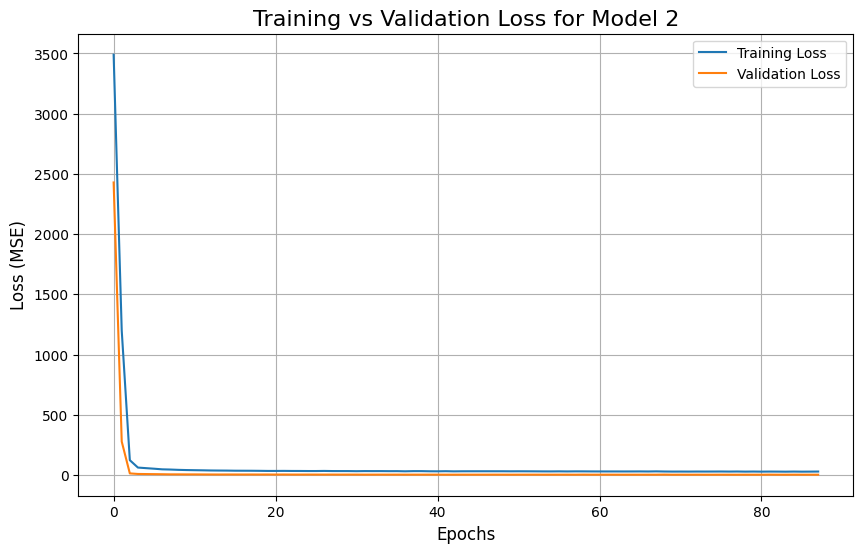

In [152]:
plt.figure(figsize=(10, 6))

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training vs Validation Loss for Model 2', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

The **loss curve** is similar to the baseline model, showing a quick drop in both **training** and **validation loss**, with the losses stabilizing afterward. This indicates the model is **learning effectively** and **generalizing well** without significant overfitting.

In [155]:
# Predictions
y_pred2 = model2.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


## Model Evaluation

In [158]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred2) / y_test)) * 100
r2 = r2_score(y_test, y_pred2)

# Adjusted R²
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

Mean Absolute Error (MAE): 1.1620891094207764
Mean Squared Error (MSE): 2.402143716812134
Root Mean Squared Error (RMSE): 1.5498850656781404
Mean Absolute Percentage Error (MAPE): 1.89%
R² Score: 0.9624058604240417
Adjusted R² Score: 0.9619633224617637


The model is performing well, with significant improvements in **MAE**, **MSE**, **RMSE**, **MAPE** and **R²**, showing it's learning and generalizing effectively.

### Predicted vs Actual Values

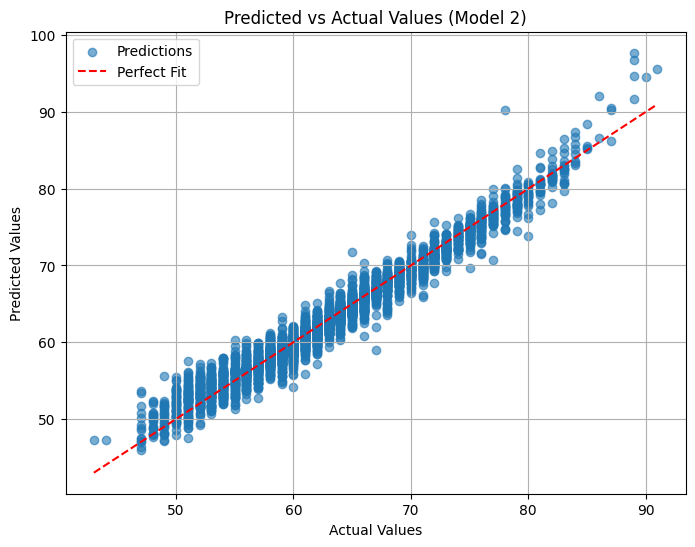

In [162]:
# Convert y_test and y_pred2 to 1D arrays
actual_values = y_test.values.flatten()
predicted_values = y_pred2.flatten()

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label='Predictions')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Model 2)')
plt.legend()
plt.grid(True)
plt.show()

The **Predicted vs Actual** plot shows strong alignment, with predictions even closer to the **Perfect Fit line**, improving on the baseline model. While the model performs well, there's still room for refinement, especially in the tails!

### Residuals Plot

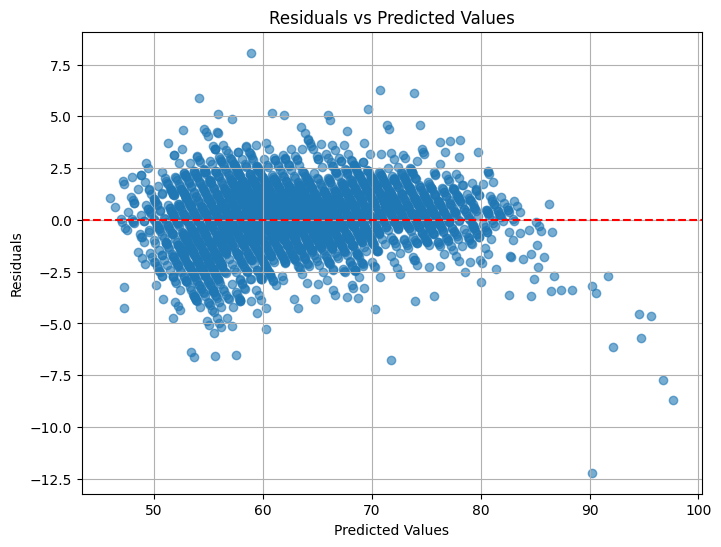

In [166]:
# Residuals
residuals = y_test - y_pred2

plt.figure(figsize=(8, 6))
plt.scatter(y_pred2, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

The **baseline model** had some larger errors and a random spread of residuals, but the **advanced model** has improved, with more evenly distributed residuals and fewer big prediction blunders!

### Distribution of Residuals

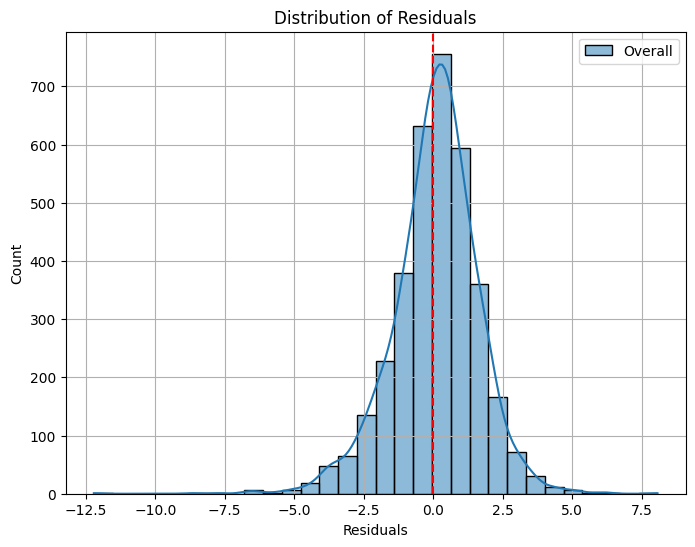

In [170]:
# Residual Distribution
residuals = y_test - y_pred2

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='steelblue')

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

The **advanced model** has a more balanced residual distribution centered around zero, while the **baseline model** was skewed towards the **negative side**, showing more large errors. The advanced model clearly outperforms in consistency and precision!

### Cumulative Error Distribution

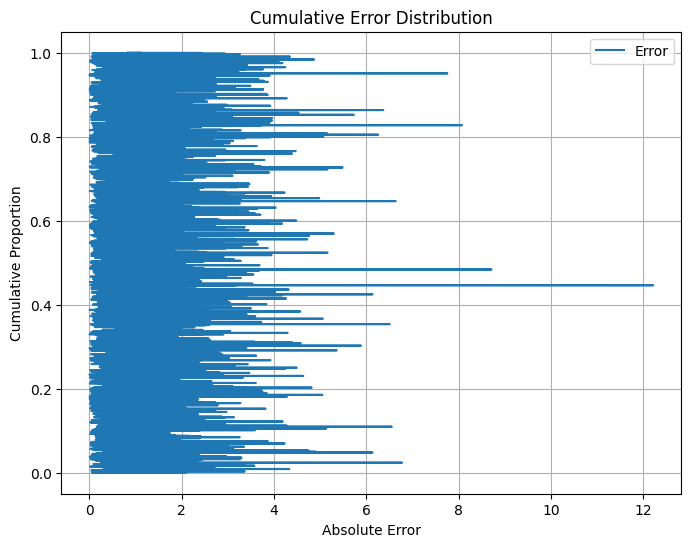

In [174]:
# Cumulative Error Distribution
absolute_errors = np.abs(y_test - y_pred2)
sorted_errors = np.sort(absolute_errors)
cumulative_errors = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 6))
plt.plot(absolute_errors, cumulative_errors, label='Error')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Error Distribution')
plt.grid(True)
plt.legend()

# Very Advanced Model: Multilayer Perceptron (MLP)

## What’s New in This Model?

We’ve pushed the limits of our MLP with exciting new changes to make it smarter, deeper, and more robust:

### 1. **Deeper Architecture**
   - Added **5 hidden layers** with **up to 1024 neurons**, giving the model more power to learn complex patterns.

### 2. **Leaky ReLU Activation**
   - Switched from **ReLU** to **Leaky ReLU**, which fixes the "dying neurons" problem and keeps learning smooth.

### 3. **Stronger Regularization**
   - Combined **L1 and L2 regularization** to control overfitting and make the model focus on the most important features.

### 4. **Increased Dropout**
   - Boosted **dropout to 40%**, making the model more resilient and better at generalizing.

### 5. **Learning Rate Decay**
   - Introduced a **learning rate scheduler** to reduce the learning rate after 50 epochs, ensuring finer adjustments during training.

### 6. **Batch Normalization Everywhere**
   - Used **Batch Normalization** after every layer for faster and more stable training.

---

## Why These Changes Matter 🚀

These enhancements give the model:
- The capacity to handle **super complex data** with ease.
- **Better generalization** by preventing overfitting through advanced regularization.
- Smoother and faster training with batch normalization and learning rate decay.

This model isn’t just advanced—it’s a powerhouse! 🌟


In [177]:
# Set random seed
seed = 56
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Learning rate decay function
def scheduler(epoch, lr):
    if epoch > 50:
        lr = lr * 0.5
    return lr

# Initialize and build the model
def build_very_advanced_model(input_dim):
    model = Sequential()

    # First hidden layer with L1_L2 regularization
    model.add(Dense(512, input_dim=input_dim, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU for better gradient flow
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Second hidden layer
    model.add(Dense(1024, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Third hidden layer
    model.add(Dense(1024, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Fourth hidden layer
    model.add(Dense(512, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Fifth hidden layer
    model.add(Dense(256, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Create the model
model3 = build_very_advanced_model(X_train.shape[1])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history3 = model3.fit(X_train, y_train, epochs=100, batch_size=32, 
                      validation_split=0.2, verbose=1, 
                      callbacks=[early_stopping, lr_scheduler])

# Model summary
model3.summary()

Epoch 1/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4273.2808 - val_loss: 1267.9401 - learning_rate: 0.0010
Epoch 2/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 942.1475 - val_loss: 568.4367 - learning_rate: 0.0010
Epoch 3/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 577.3354 - val_loss: 426.2293 - learning_rate: 0.0010
Epoch 4/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 431.4376 - val_loss: 299.7873 - learning_rate: 0.0010
Epoch 5/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 305.1277 - val_loss: 202.5646 - learning_rate: 0.0010
Epoch 6/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 220.8554 - val_loss: 154.5445 - learning_rate: 0.0010
Epoch 7/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 173.8669 - val_loss: 126.0402 - learning_rate: 0.0010
Epoch 8/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 150.0215 - val_loss: 118.7262 - learning_rate: 0.0010
Epoch 9/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 136.2517

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,785,029 (25.88 MB)

 Trainable params: 2,259,457 (8.62 MB)

 Non-trainable params: 6,656 (26.00 KB)

 Optimizer params: 4,518,916 (17.24 MB)

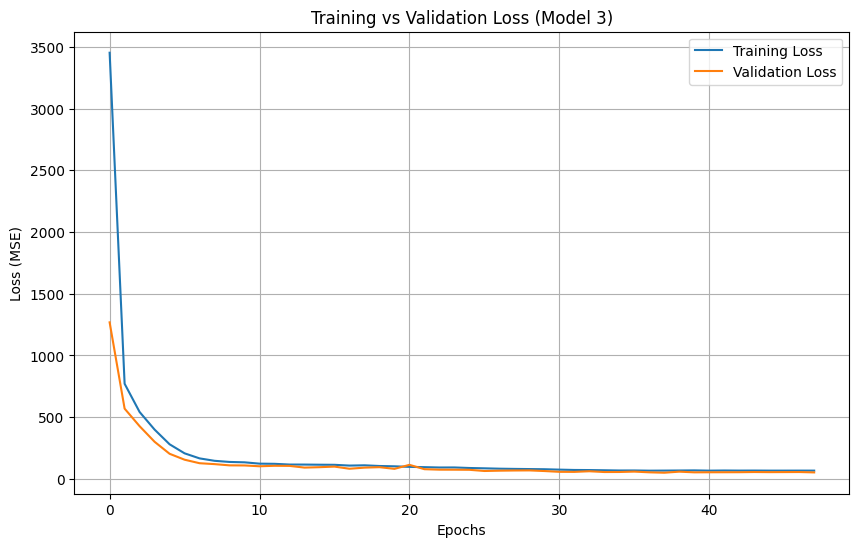

In [179]:
plt.figure(figsize=(10, 6))

plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss (Model 3)')
plt.legend()
plt.grid(True)
plt.show()

In [181]:
y_pred3 = model3.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Model Evaluation

In [184]:
# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred3)
mse = mean_squared_error(y_test, y_pred3)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred3)
mape = np.mean(np.abs((y_test - y_pred3) / y_test)) * 100

# Adjusted R²
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

Mean Absolute Error (MAE): 1.3668729066848755
Mean Squared Error (MSE): 3.3209421634674072
Root Mean Squared Error (RMSE): 1.822345237178567
Mean Absolute Percentage Error (MAPE): 2.20%
R² Score: 0.9480264186859131
Adjusted R² Score: 0.9474146136804932


### Predicted vs Actual Values

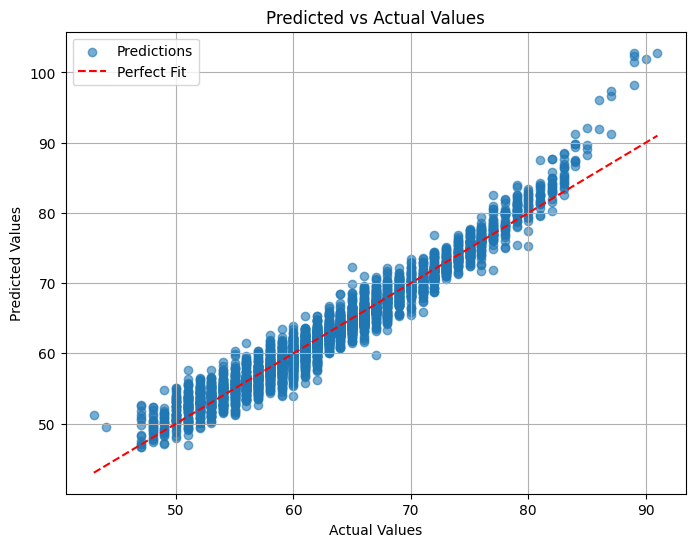

In [187]:
# Convert y_test and y_pred3 to 1D arrays
actual_values = y_test.values.flatten()
predicted_values = y_pred3.flatten()

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label='Predictions')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### Residuals Plot

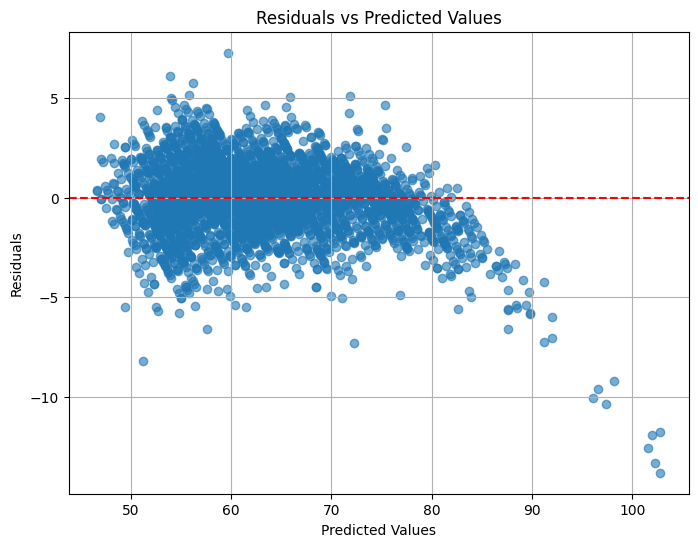

In [189]:
# Residuals
residuals = y_test - y_pred3

plt.figure(figsize=(8, 6))
plt.scatter(y_pred3, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

### Distribution of Residuals

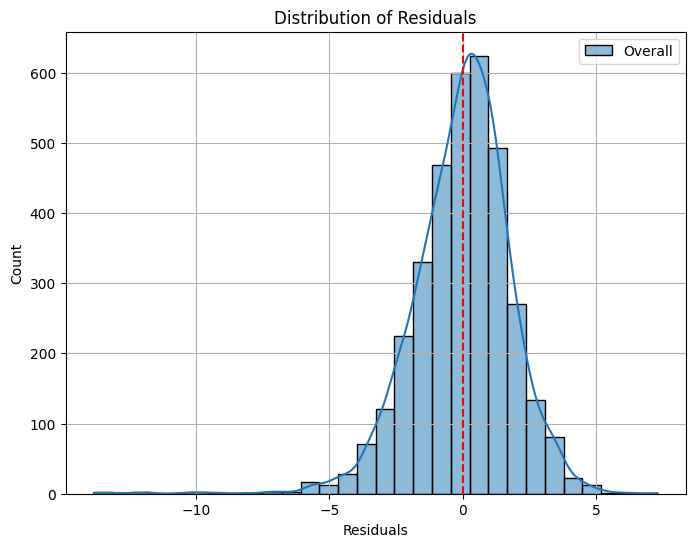

In [192]:
# Residual Distribution
residuals = y_test - y_pred3

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='steelblue')

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

### Cumulative Error Distribution

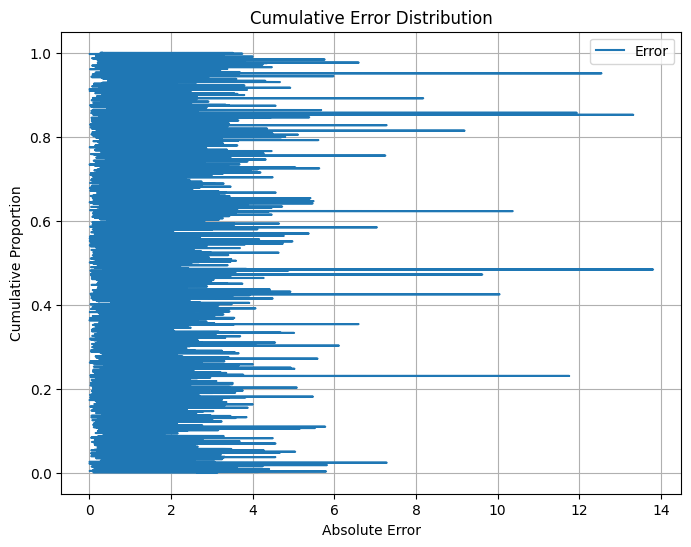

In [195]:
# Cumulative Error Distribution
absolute_errors = np.abs(y_test - y_pred3)
sorted_errors = np.sort(absolute_errors)
cumulative_errors = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 6))
plt.plot(absolute_errors, cumulative_errors, label='Error')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Error Distribution')
plt.grid(True)
plt.legend()

# Hyperparameter tunning

In [198]:
# Set random seed
seed = 56
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_layer1', min_value=64, max_value=256, step=64),
        input_dim=X_train.shape[1],
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_layer1', min_value=0.0001, max_value=0.01, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_layer1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_layer2', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_layer2', min_value=0.0001, max_value=0.01, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_layer2', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
        loss='mean_squared_error'
    )
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train for each trial
    directory='my_dir',
    project_name='model2_hyperparameter_tuning'
)

# Run the search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the model with the best hyperparameters
model2 = tuner.hypermodel.build(best_hps)
history2 = model2.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1, callbacks=[early_stopping])

# Summary of the tuned model
model2.summary()

Trial 30 Complete [00h 00m 21s]
val_loss: 3.5617458820343018

Best val_loss So Far: 2.104794144630432
Total elapsed time: 00h 41m 09s
Epoch 1/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - loss: 3481.3159 - val_loss: 433.2413
Epoch 2/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 178.8448 - val_loss: 11.4934
Epoch 3/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 38.6050 - val_loss: 9.0947
Epoch 4/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 32.8994 - val_loss: 6.8602
Epoch 5/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 29.0444 - val_loss: 6.6512
Epoch 6/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 26.7843 - val_loss: 5.6008
Epoch 7/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 24.6501 - val_loss: 6.8331
Epoch 8/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 23.2768 - val_loss: 4.7414
Epoch 9/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 21.1263 - val_loss: 4.2120
Epoch 10/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 453us

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,949 (136.52 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 23,044 (90.02 KB)

In [199]:
print(f"""
The optimal number of units in the first hidden layer is {best_hps.get('units_layer1')}.
The optimal number of units in the second hidden layer is {best_hps.get('units_layer2')}.
The optimal dropout rates are {best_hps.get('dropout_layer1')} and {best_hps.get('dropout_layer2')}.
The optimal L2 regularization strengths are {best_hps.get('l2_layer1')} and {best_hps.get('l2_layer2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the first hidden layer is 64.
The optimal number of units in the second hidden layer is 128.
The optimal dropout rates are 0.4 and 0.2.
The optimal L2 regularization strengths are 0.00012774647846526554 and 0.0010353208241115615.
The optimal learning rate is 0.0013369104602961573.



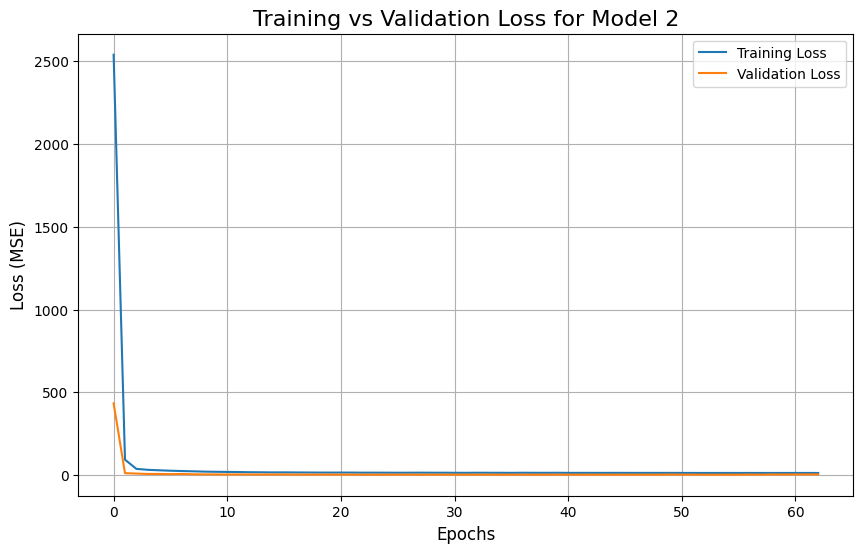

In [200]:
plt.figure(figsize=(10, 6))

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training vs Validation Loss for Model 2', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [201]:
# Predictions
y_pred2 = model2.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


## Model Evaluation

In [203]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred2) / y_test)) * 100
r2 = r2_score(y_test, y_pred2)

# Adjusted R²
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

Mean Absolute Error (MAE): 1.0312575101852417
Mean Squared Error (MSE): 1.9828791618347168
Root Mean Squared Error (RMSE): 1.408147421911043
Mean Absolute Percentage Error (MAPE): 1.69%
R² Score: 0.9689674377441406
Adjusted R² Score: 0.9686021391359034


### Predicted vs Actual Values

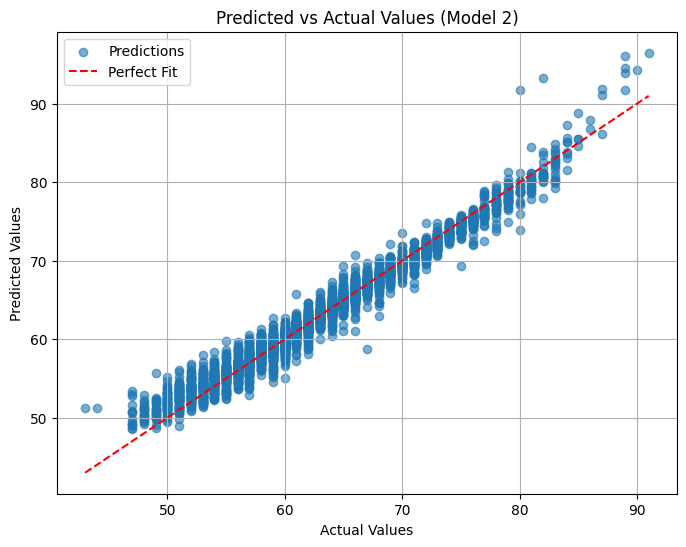

In [205]:
# Convert y_test and y_pred2 to 1D arrays
actual_values = y_test.values.flatten()
predicted_values = y_pred2.flatten()

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label='Predictions')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Model 2)')
plt.legend()
plt.grid(True)
plt.show()

### Residuals Plot

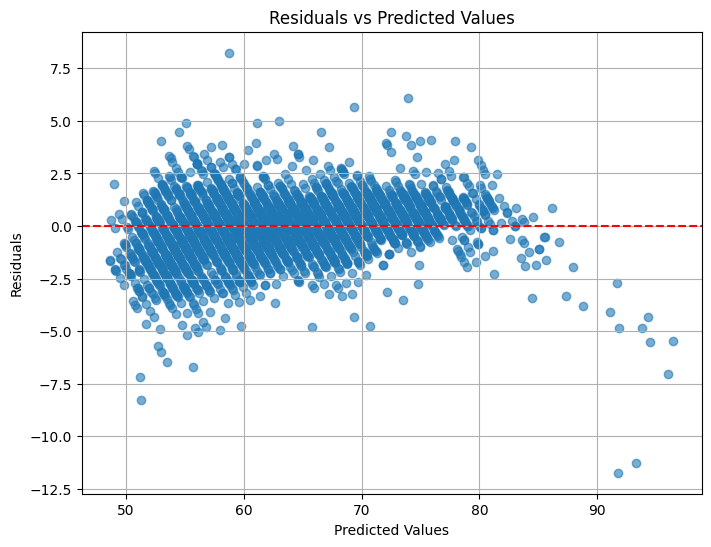

In [207]:
# Residuals
residuals = y_test - y_pred2

plt.figure(figsize=(8, 6))
plt.scatter(y_pred2, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

### Distribution of Residuals

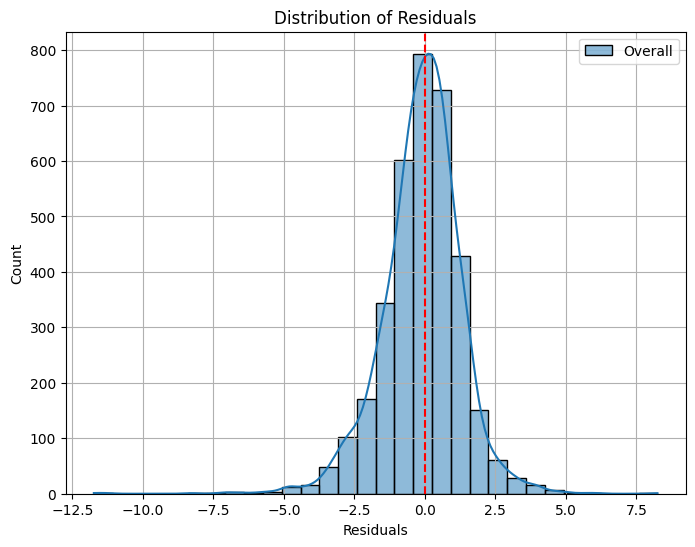

In [209]:
# Residual Distribution
residuals = y_test - y_pred2

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='steelblue')

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

# Cumulative Error Distribution

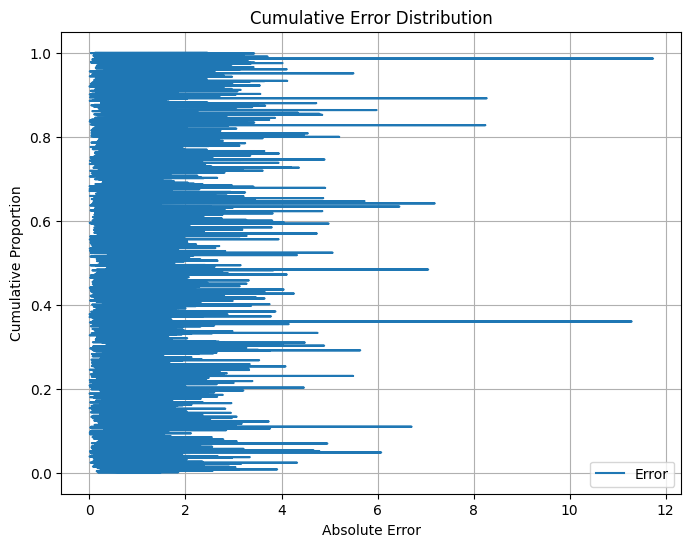

In [211]:
# Cumulative Error Distribution
absolute_errors = np.abs(y_test - y_pred2)
sorted_errors = np.sort(absolute_errors)
cumulative_errors = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 6))
plt.plot(absolute_errors, cumulative_errors, label='Error')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Error Distribution')
plt.grid(True)
plt.legend()

# Feature Importance

In [248]:
# Compute permutation importance directly using Keras model
perm_importance = permutation_importance(
    estimator=model2,  # Use the Keras model directly
    X=X_test,
    y=y_test,
    scoring="neg_mean_squared_error",  # Specify the scoring metric
    n_repeats=10,  # Number of shuffles per feature
    random_state=56
)

# Display feature importance
for i, score in enumerate(perm_importance.importances_mean):
    print(f"Feature {i}: Importance = {score:.4f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
111/111 ━━━

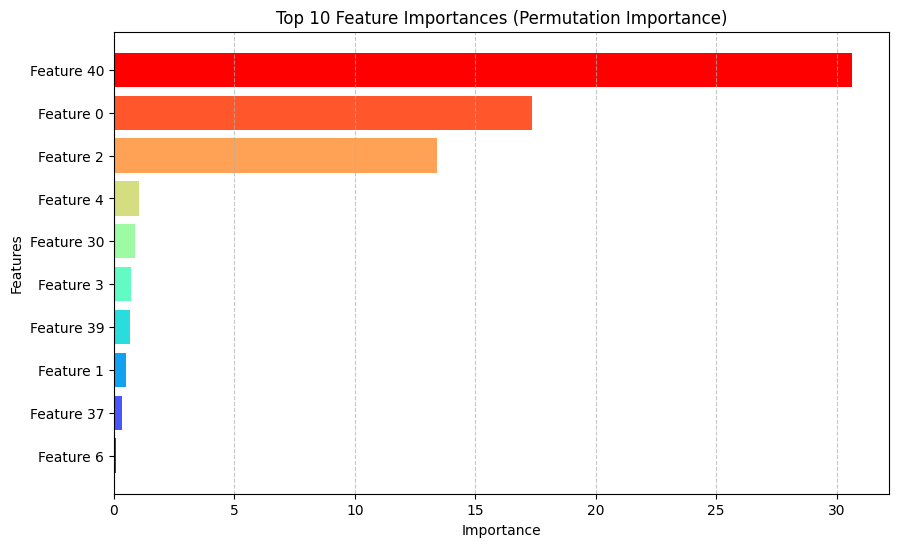

In [250]:
# Extract and sort feature importances
importances = perm_importance.importances_mean
top_10_indices = importances.argsort()[-10:]  # Indices of top 10 features
top_10_importances = importances[top_10_indices]
top_10_feature_names = [f"Feature {i}" for i in top_10_indices]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(top_10_importances)))  # Rainbow colors
plt.barh(top_10_feature_names, top_10_importances, color=colors)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (Permutation Importance)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Summary of Results

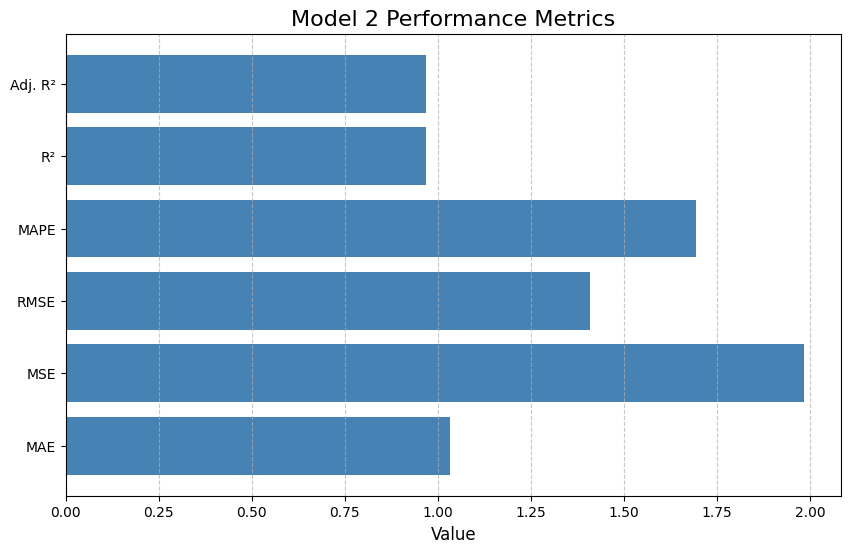

In [262]:
# Metrics data
metrics = {
    "Metric": ["MAE", "MSE", 
               "RMSE", "MAPE", 
               "R²", "Adj. R²"],
    "Value": [mae, mse, rmse, mape, r2, adjusted_r2]  # Replace with your actual computed values
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plotting the metrics as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(metrics_df['Metric'], metrics_df['Value'], color='steelblue')
plt.xlabel('Value', fontsize=12)
plt.title('Model 2 Performance Metrics', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [266]:
metrics_df

,Metric,Value
0,MAE,1.031258
1,MSE,1.982879
2,RMSE,1.408147
3,MAPE,1.692725
4,R²,0.968967
5,Adj. R²,0.968602
